## Task

Use the image `data/candy.jpg` for this task!

Count the how many:
* colors are on the picture
* what is the proportion of each type of candy on the picture!


In [1]:
!pip install opencv-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage import io, morphology, measure
from matplotlib import colors
from collections import Counter


#plt.rcParams['text.usetex'] = True

(<matplotlib.image.AxesImage at 0x1de89d34e20>, (1069, 736, 3))

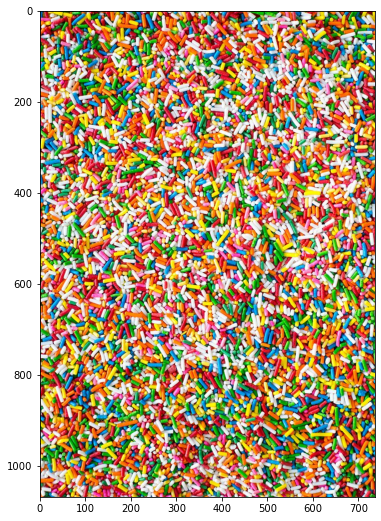

In [3]:
img = cv2.imread("data/candy.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=[6,10])
plt.imshow(img), img.shape

In [4]:
#It would be a waste of time wait for the visualiziation of all 700k pixels, so I'm going to draw some randomly.

pixel_pool = img[np.random.randint(0,1068, 1500), np.random.randint(0,735, 1500), :]
r, g, b = pixel_pool[:,0], pixel_pool[:,1], pixel_pool[:,2]

In [5]:
pixel_colors = pixel_pool.reshape(-1, 3)
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

In [6]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
    x=r.flatten(),
    y=g.flatten(),
    z=b.flatten(),
    mode='markers',
    marker=dict( size=2, color=pixel_colors, opacity=0.8)
    ))
fig.update_layout(scene = dict(xaxis_title="red", yaxis_title="green", zaxis_title="blue"))

fig.update_layout(margin = dict(r=20, b=10, l=10, t=10)) #much of the picture is clipped otherwise
fig.show()

On the first figure above, there are some sprinkles in different colors. I can see sprinkles in 7 different colors, if I'm correct: yellow, green, blue, orange, white, red and pink. I'm going to use this intuition in next exercise to guess the number of colors on the picture.

Naturally, the color of the sprinkles are perceived to be the same, however, by taking a picture of them, the light reflected from them is not homogenious - as it can be seen on the second figure. So, solely looking at indivudal pixel values is not going to answer the question.

We need to group each pixel's color (by their RGB value), so that we can make some generalizations about the colors. One way to do is using the k-means algorithm.

In [7]:
img = img.reshape(-1,3) #flattening the image

In [8]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters = 7)
clustering.fit(img)
clustering.cluster_centers_ ,  clustering.cluster_centers_.reshape(1,-1,3)
#These values are not integers, so we have to convert them to get 

(array([[233.61405379, 229.36381793, 227.20182564],
        [189.35382757,  53.81605746,  39.82733104],
        [ 49.27945662, 152.23543069,  46.47018215],
        [236.72759918, 171.40327673,  30.84060551],
        [ 62.66204677,  40.73512698,  23.57633392],
        [ 28.17523802, 141.46313717, 189.13758967],
        [208.24900281, 153.54587982, 142.63313604]]),
 array([[[233.61405379, 229.36381793, 227.20182564],
         [189.35382757,  53.81605746,  39.82733104],
         [ 49.27945662, 152.23543069,  46.47018215],
         [236.72759918, 171.40327673,  30.84060551],
         [ 62.66204677,  40.73512698,  23.57633392],
         [ 28.17523802, 141.46313717, 189.13758967],
         [208.24900281, 153.54587982, 142.63313604]]]))

In [9]:
rounded_kmeans = clustering.cluster_centers_.reshape(1,-1,3).astype(int)

Text(0.5, 1.0, 'Sprinkle colors: k-means, $k=7$')

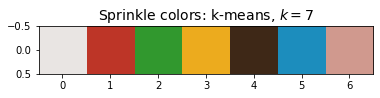

In [10]:
plt.figure(figsize=[6,3])
plt.imshow(rounded_kmeans)
plt.title("Sprinkle colors: k-means, $k=7$",size=14)

In [11]:
sorted(Counter(clustering.labels_).most_common())

[(0, 163733),
 (1, 152249),
 (2, 80897),
 (3, 129111),
 (4, 99452),
 (5, 52862),
 (6, 108480)]

In [12]:
labels = clustering.labels_.reshape(1069, 736)
count_dict = {}


for i in np.unique(clustering.labels_):
    blobs = np.int_(morphology.binary_opening(labels == i))
    color = np.around(clustering.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1

    count_dict[i] = [count, color]

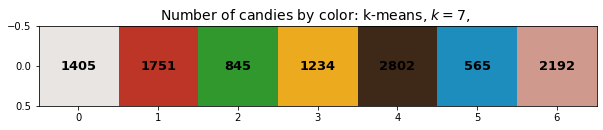

In [13]:
plt.figure(figsize=[10,5])
plt.imshow(rounded_kmeans)
plt.title("Number of candies by color: k-means, $k=7$,  ",size=14)
for i in range(7):
    plt.text(i,0,count_dict[i][0], color ="black", size=13, ha="center",va="center", fontweight='bold' )

Based on the figure above, we can say, that the k-means algorithm did a pretty good job by segmenting the picture by colors. Even though most of the colors seem to be accurate, there are two things going sideways. There's no brown candy in the image - so number 5 shouldn't be brown neither. Moreover, the first color seems to be the mixture of yellow and orange.

Text(0.5, 1.0, 'Sprinkle colors: k-means, $k=8$ ')

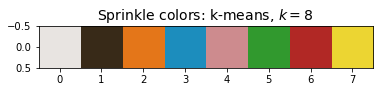

In [14]:
clustering = KMeans(n_clusters = 8)
clustering.fit(img)
rounded_kmeans = clustering.cluster_centers_.reshape(1,-1,3).astype(int)

plt.figure(figsize=[6,3])
plt.imshow(rounded_kmeans)
plt.title("Sprinkle colors: k-means, $k=8$ ",size=14)

Fortunately, by increasing to $k=8$ now the algorithm detects the centroid of the yellow colored sprinkles.

In [15]:
sorted(Counter(clustering.labels_).most_common()) #Number of pixels assigned to each centroid

[(0, 168642),
 (1, 92671),
 (2, 97537),
 (3, 52632),
 (4, 97230),
 (5, 78862),
 (6, 123521),
 (7, 75689)]

In [16]:
labels = clustering.labels_.reshape(1069, 736)
count_dict = {}


for i in np.unique(clustering.labels_):
    blobs = np.int_(morphology.binary_opening(labels == i))
    color = np.around(clustering.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1

    count_dict[i] = [count, color]


#source: https://stackoverflow.com/questions/45043617/count-the-number-of-objects-of-different-colors-in-an-image-in-python/45080346

In [17]:
count_dict

{0: [1373, array([233., 228., 226.])],
 1: [2629, array([57., 43., 24.])],
 2: [1166, array([228., 119.,  26.])],
 3: [570, array([ 28., 142., 189.])],
 4: [1865, array([205., 140., 142.])],
 5: [848, array([ 49., 153.,  46.])],
 6: [1588, array([178.,  41.,  38.])],
 7: [1037, array([237., 213.,  50.])]}

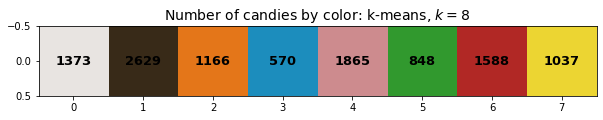

In [18]:
plt.figure(figsize=[10,5])
plt.imshow(rounded_kmeans)
plt.title("Number of candies by color: k-means, $k=8$ ",size=14)
for i in range(8):
    plt.text(i,0,count_dict[i][0], color ="black", size=13, ha="center",va="center", fontweight='bold' )